<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/place365_mnist_wb_dist_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

#not_patch_path = oj(data_path, "processed", "no_waterbird_224")
#patch_path = oj(data_path, "processed", "waterbird_224")

In [ ]:

import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

#for module in model.classifier.children():
    #if isinstance(module, nn.Dropout):
        #module.p = dropout_rate

params_to_update = model.parameters()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 197MB/s]


In [ ]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")

In [ ]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files = None, labels = None, group_labels = None):
        """
        Expects path and is_two both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the MNISTDataset.

        If 'path' and 'is_two' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_two'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_two (int): The class label (e.g., 1 for two, 0 for zero) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.group_labels = [is_two] * len(self.data_files)  # Assuming group labels are consistent within the directory

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels
            self.is_two = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]
        return (torch_img, is_two, group_label)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

## Functions for Training

In [ ]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''Assume that everything is already on cuda.'''
    im.requires_grad = True  # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False, patience=10):
    since = time.time()
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 5  # Counter for early stopping

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    if len(os.listdir(model_training_path)) > 0 and resume_training:
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            for i, (inputs, labels, group_labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and regularizer_rate != 0:
                        add_loss = gradient_sum(inputs, labels, model, criterion)
                        if add_loss != 0:
                            (regularizer_rate * add_loss).backward()
                            optimizer.step()
                        optimizer.zero_grad()
                        running_loss_cd += add_loss.item() * inputs.size(0)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_cd_loss = running_loss_cd / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} CD Loss: {epoch_cd_loss:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  # Reset early stopping counter
                else:
                    epochs_no_improve += 1

        scheduler.step()

        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + "alexnet_wb" + ".pt"))

        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch} as validation loss has not improved for {patience} epochs.')
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


## Train

In [ ]:
train_two_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/train/two_water'
train_zero_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/train/zero_water'
train_zero_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/train/zero_land'




test_two_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water'
test_two_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land'


# Create datasets for training and testing
dataset_two_nopatch = MNISTDataset(path=train_two_nopatch_path, is_two=1, group_labels=[2] * len(os.listdir(train_two_nopatch_path)))
dataset_zero_patch = MNISTDataset(path=train_zero_patch_path, is_two=0, group_labels=[0] * len(os.listdir(train_zero_patch_path)))
dataset_zero_nopatch = MNISTDataset(path=train_zero_nopatch_path, is_two=0, group_labels=[1] * len(os.listdir(train_zero_nopatch_path)))

#Test
dataset_two_patch = MNISTDataset(path=test_two_patch_path, is_two=1, group_labels=[3] * len(os.listdir(test_two_patch_path)))


complete_dataset = ConcatDataset((dataset_two_nopatch, dataset_zero_patch, dataset_zero_nopatch))
#train_dataset = complete_dataset

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])


test_dataset = dataset_two_patch

batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])


In [ ]:
two_ratio = len(dataset_two_nopatch)/len(complete_dataset)

not_two_ratio = 1 - two_ratio
two_weight = 1/two_ratio
not_two_weight = 1/ not_two_ratio
weights = np.asarray([not_two_weight, two_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0


regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
seeds = [1, 11, 111]


torch.manual_seed(args.seed)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()





for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize model, optimizer, and loss function
    params_to_update = model.parameters()
   #initialize_weights(model)
    optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
    #criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"places_mnist_wb_dist_{seed}" + "train.pt"))

## Extracting activations: Correlations

Computing activations and saving to activations.npy
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water
Found 602 images in /content/drive/MyDrive/Masterthesis/Datasets/combi

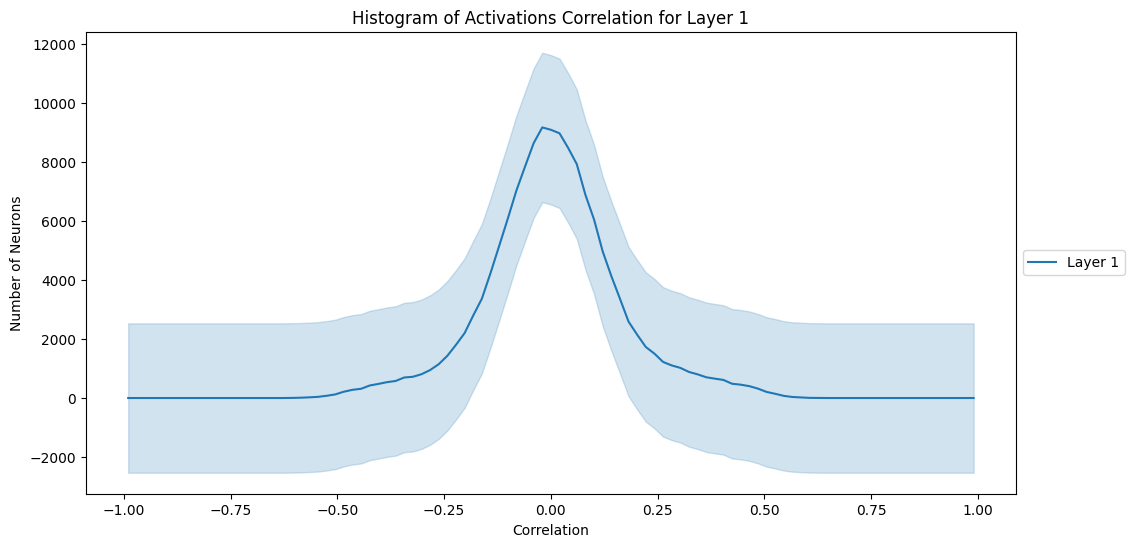

<ipython-input-15-a0466370bd2a>:180: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


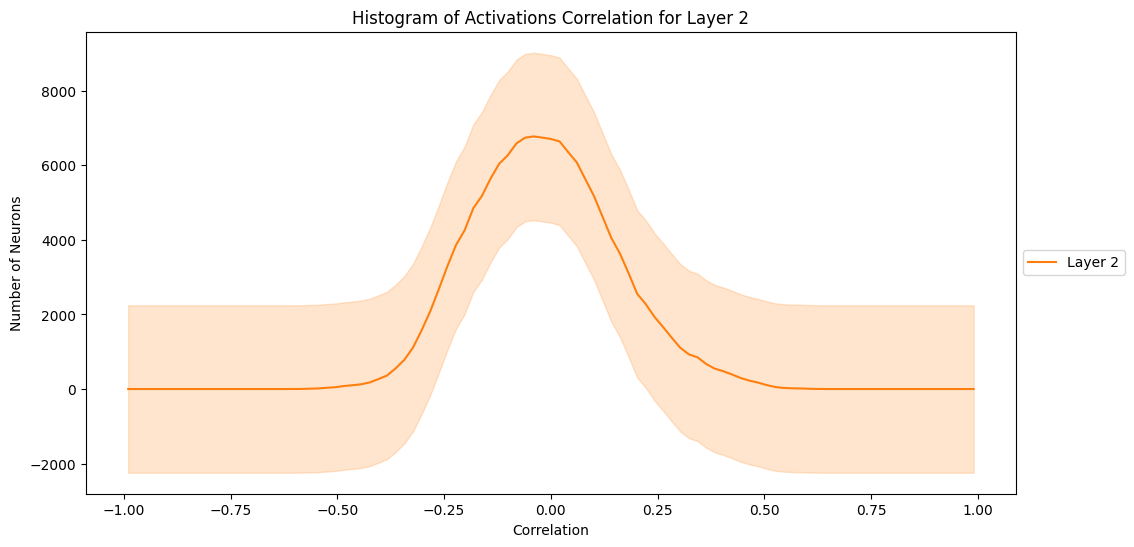

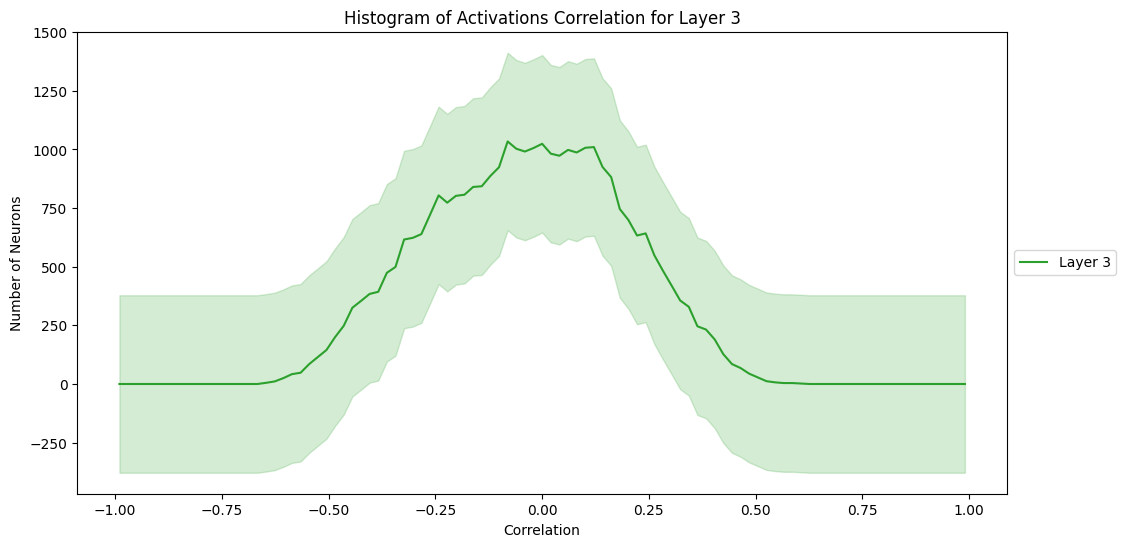

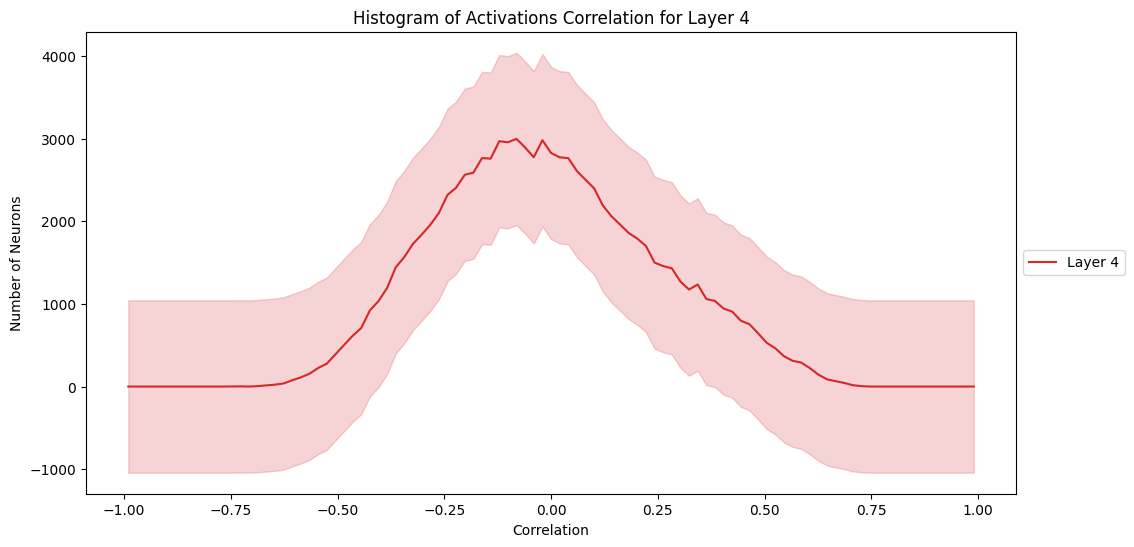

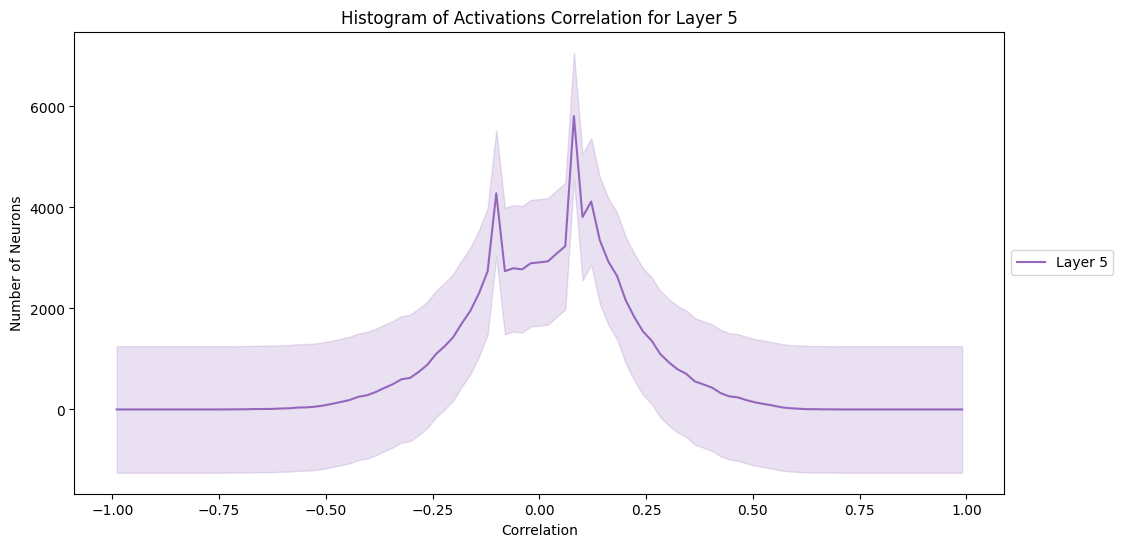

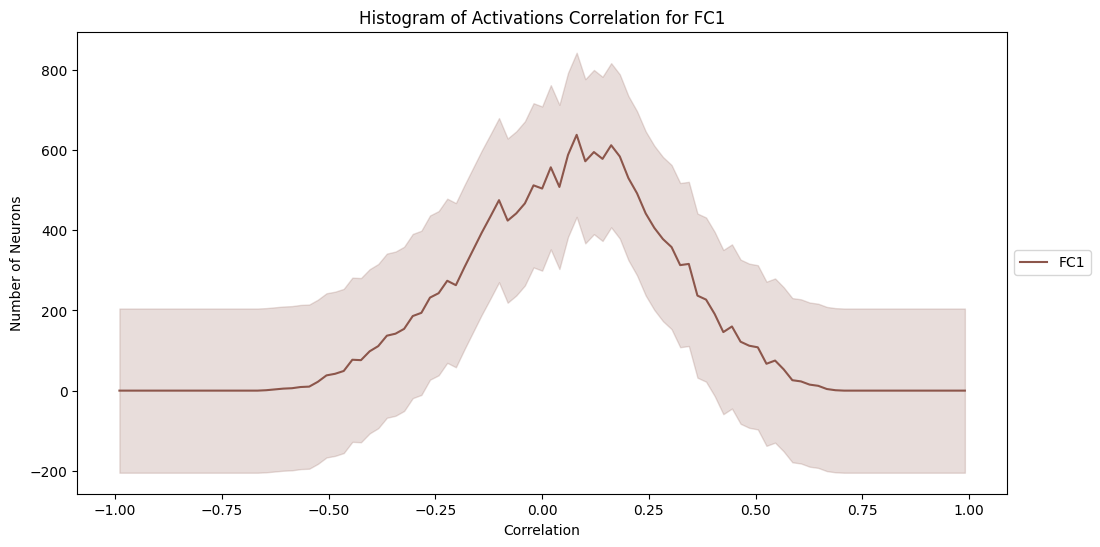

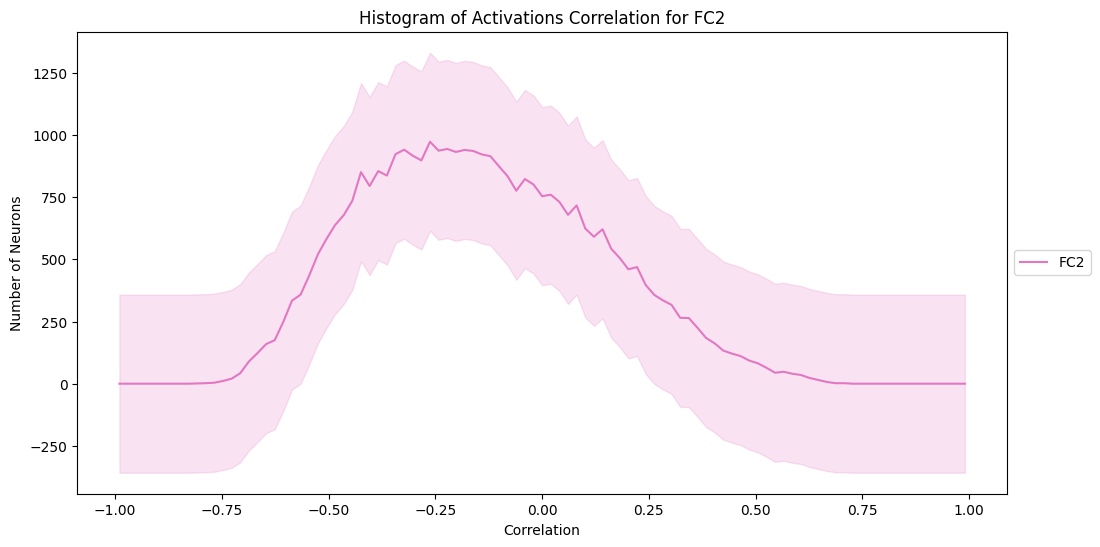

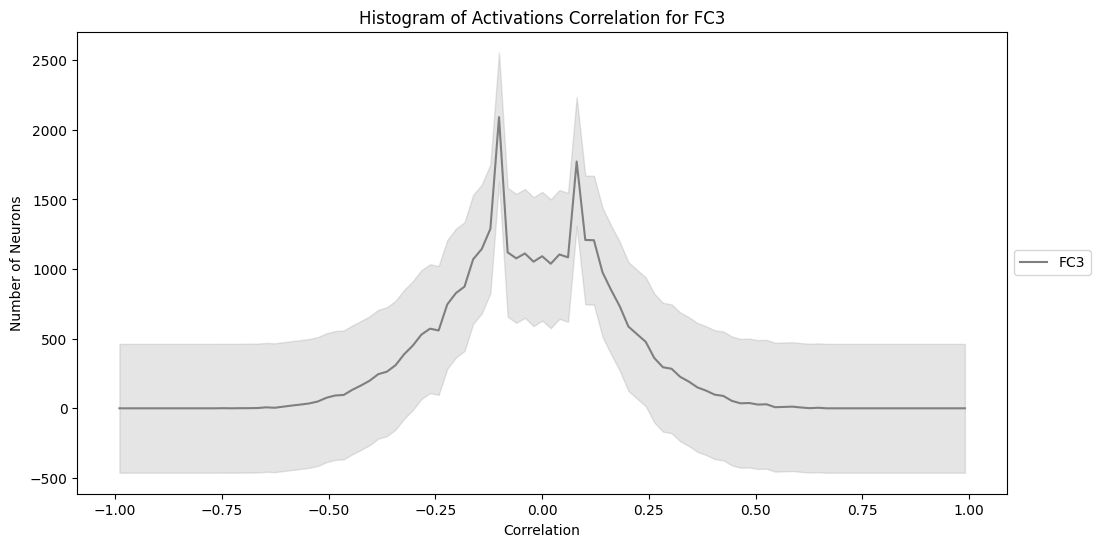

<ipython-input-15-a0466370bd2a>:218: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


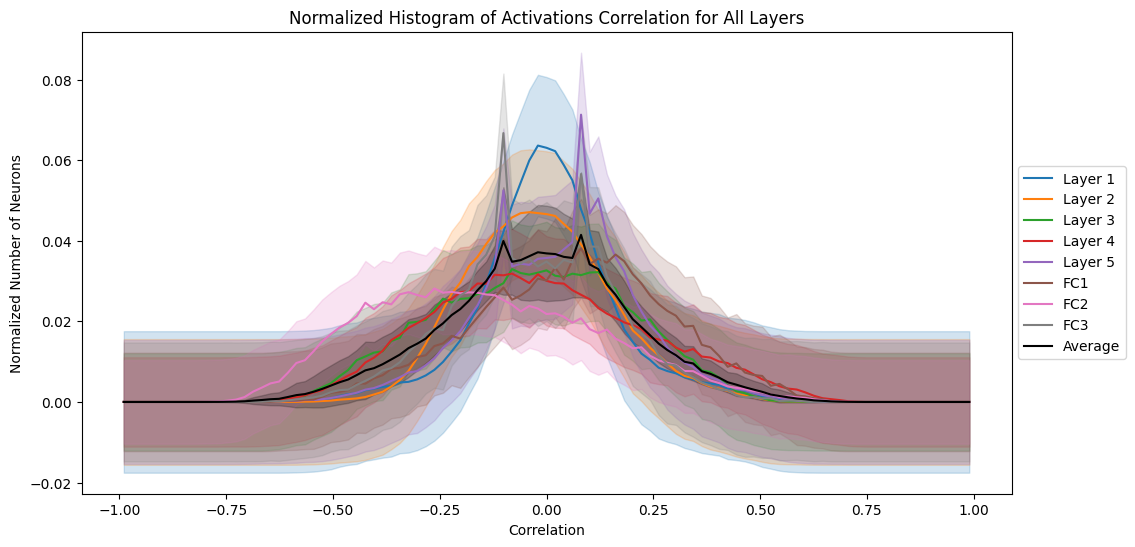

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    print(f"Found {len(image_paths)} images in {folder_path}") # Check if images are found

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/activations/water/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/activations/land/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('background', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'water', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'land', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

water_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_water'
land_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/test/two_land'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/models/initial_classifier/places_mnist_wb_dist_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/models/initial_classifier/places_mnist_wb_dist_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/models/initial_classifier/places_mnist_wb_dist_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, water_mnist_folder_path, land_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


## Extracting Activations: T-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/combined/mnist_wb/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both background and original conditions
background_activations = {layer: load_activations('water', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('land', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(background_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: -0.3407
  WO Activations:
    Mean: -0.3532
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 43.69%
    Percentage of neurons with raw p-value <= 0.02: 36.42%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 10.63%
    Percentage of neurons with adjusted p-value <= 0.02: 9.97%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 0.6758
  WO Activations:
    Mean: 0.7030
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 54.84%
    Percentage of neurons with raw p-value <= 0.02: 47.64%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 11.57%
    Percentage of neurons with adjusted p-value <= 0.02: 10.36%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 2.1842
  WO Activations:
    Mean: 2.3287
  T-Te